# Stock Exchange Data

This dataset consists of stock exchange data since 1965 for several indexes. It contains the daily stock prices along with the volume traded each day.

The point of this notebook was to explore the `timetk` and `modeltime` packages rather than work through a comprehensive time series analysis and forecasting modelling exercise.

## Data Dictionary

| Variable | Explanation |
|-------|-------|
| Index | Ticker symbol for indexes |
| Date | Date of observation |
| Open | Opening price |
| High | Highest price during trading day |
| Low | Lowest price during trading day |
| Close | Close price |
| Adj Close | Closing price adjusted for dividends and stock splits |
| Volume | Number of shares traded during trading day |
| CloseUSD | Close price in terms of USD |

[Source](https://www.kaggle.com/mattiuzc/stock-exchange-data) of dataset.

In [1]:
# install non-native packages
install.packages(c("timetk", "modeltime", "earth"))

Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/timetk_2.8.1.tar.gz' ...
	OK [downloaded 2.6 Mb in 0.6 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/padr_0.6.0.tar.gz' ...
	OK [downloaded 3.2 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/anytime_0.3.9.tar.gz' ...
	OK [downloaded 1.5 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/BH_1.78.0-0.tar.gz' ...
	OK [downloaded 11.8 Mb in 0.7 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/forecast_8.16.tar.gz' ...
	OK [downloaded 3.8 Mb in 0.5 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/fracdiff_1.5-1.tar.gz' ...
	OK [downloaded 134.5 Kb in 0.2 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/lmtest_0.9-40.tar.gz' ...
	O

In [2]:
# load necessary libraries
library(xgboost)
library(tidymodels)
library(modeltime)
library(tidyverse)
library(lubridate)
library(timetk)

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.8.0     ✔ recipes      0.2.0
✔ dials        0.1.1     ✔ rsample      0.1.1
✔ dplyr        1.0.9     ✔ tibble       3.1.7
✔ ggplot2      3.3.6     ✔ tidyr        1.2.0
✔ infer        1.0.0     ✔ tune         0.2.0
✔ modeldata    0.1.1     ✔ workflows    0.2.6
✔ parsnip      0.2.1     ✔ workflowsets 0.2.1
✔ purrr        0.3.4     ✔ yardstick    0.0.9

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::slice()   masks xgboost::slice()
✖ recipes::step()  masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ forcats 0.5.1
✔ stringr 1.4.0     

── Conflicts ────────────────────────────────────

In [3]:
# set whether we want interactive (plotly) or non-interactive (ggplot) charts
interactive <- TRUE

In [4]:
data <- read_csv('data/stock_exchange.csv.gz', show_col_types = FALSE)
str(data)

spec_tbl_df [104,224 × 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Index    : chr [1:104224] "HSI" "HSI" "HSI" "HSI" ...
 $ Date     : Date[1:104224], format: "1986-12-31" "1987-01-02" ...
 $ Open     : num [1:104224] 2568 2540 2552 2584 2607 ...
 $ High     : num [1:104224] 2568 2540 2552 2584 2607 ...
 $ Low      : num [1:104224] 2568 2540 2552 2584 2607 ...
 $ Close    : num [1:104224] 2568 2540 2552 2584 2607 ...
 $ Adj Close: num [1:104224] 2568 2540 2552 2584 2607 ...
 $ Volume   : num [1:104224] 0 0 0 0 0 0 0 0 0 0 ...
 $ CloseUSD : num [1:104224] 334 330 332 336 339 ...
 - attr(*, "spec")=
  .. cols(
  ..   Index = col_character(),
  ..   Date = col_date(format = ""),
  ..   Open = col_double(),
  ..   High = col_double(),
  ..   Low = col_double(),
  ..   Close = col_double(),
  ..   `Adj Close` = col_double(),
  ..   Volume = col_double(),
  ..   CloseUSD = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [5]:
# take a look at what indexes are present
table(data$Index)


000001.SS 399001.SZ     GDAXI    GSPTSE       HSI      IXIC   J203.JO      N100 
     5791      5760      8438     10526      8492     12690      2346      5474 
     N225      NSEI       NYA      SSMI      TWII 
    13874      3346     13947      7671      5869 

## Step 1: Collect data and split into training and test sets

In [6]:
data <- data %>% 
    # just keep the date and adjusted close columns
    select(c(Index, Date, `Adj Close`)) %>%
    rename(AdjClose = `Adj Close`)
head(data)

Index,Date,AdjClose
<chr>,<date>,<dbl>
HSI,1986-12-31,2568.3
HSI,1987-01-02,2540.1
HSI,1987-01-05,2552.4
HSI,1987-01-06,2583.9
HSI,1987-01-07,2607.1
HSI,1987-01-08,2603.3


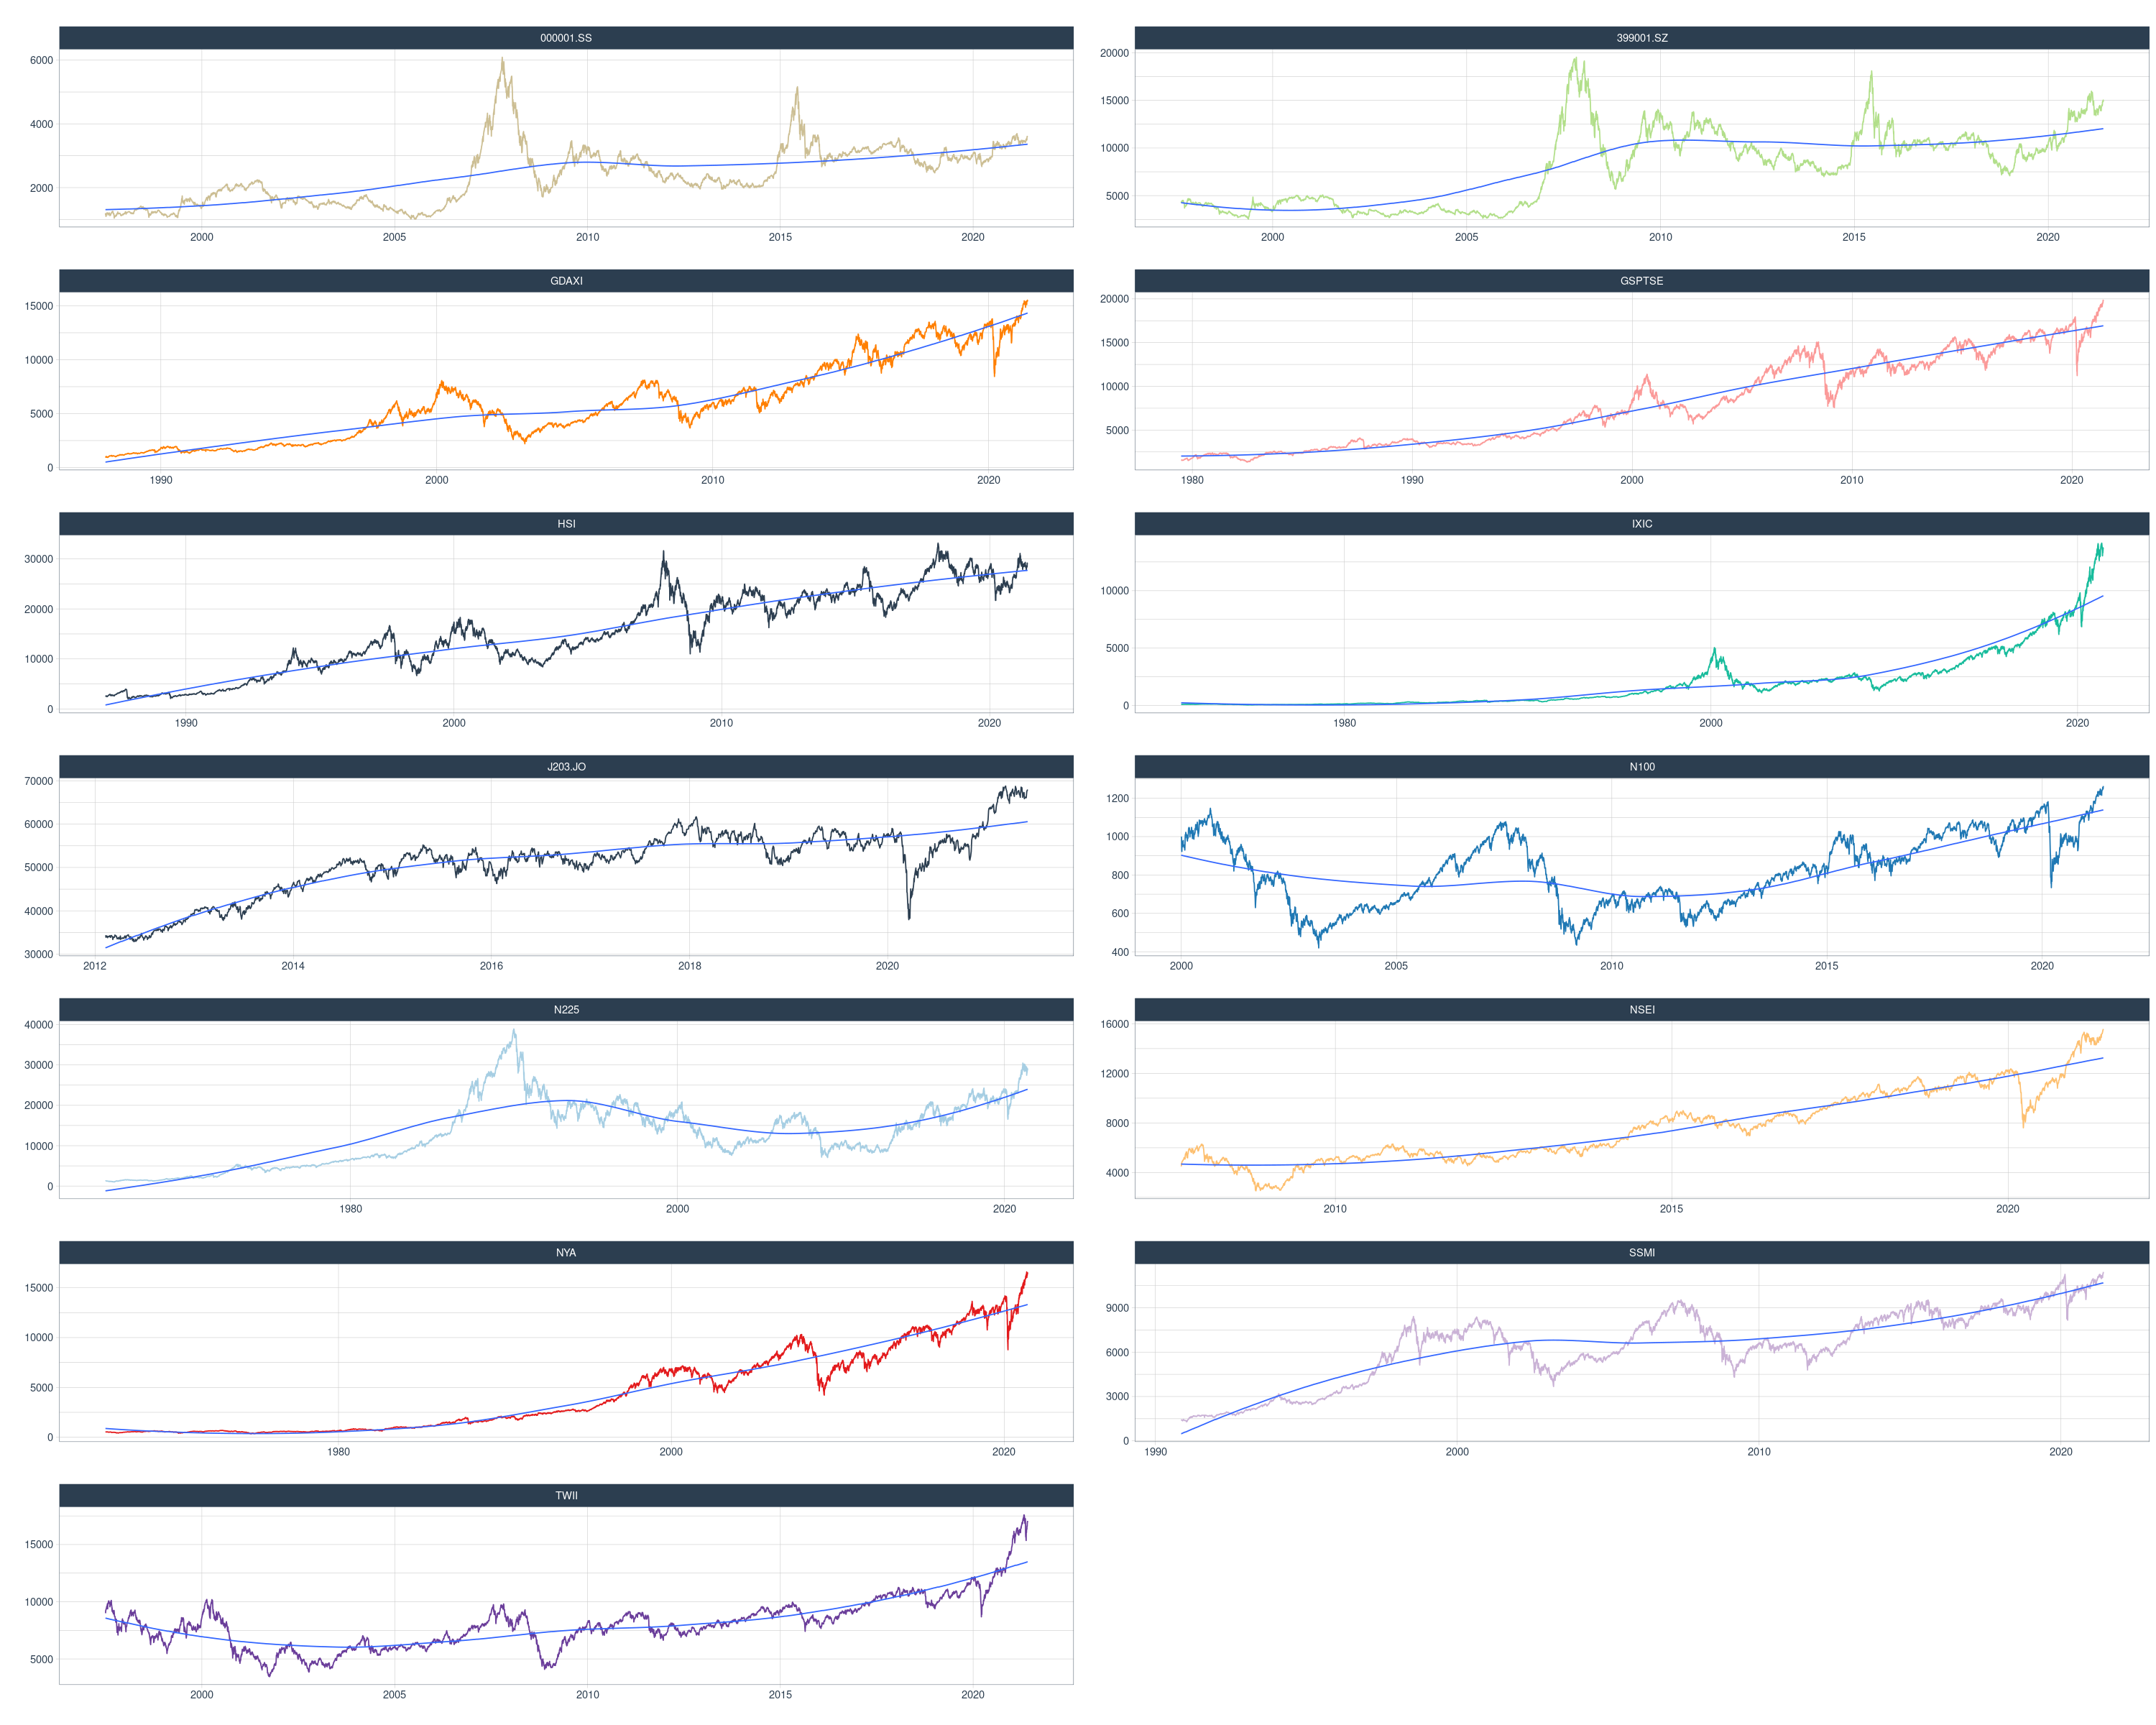

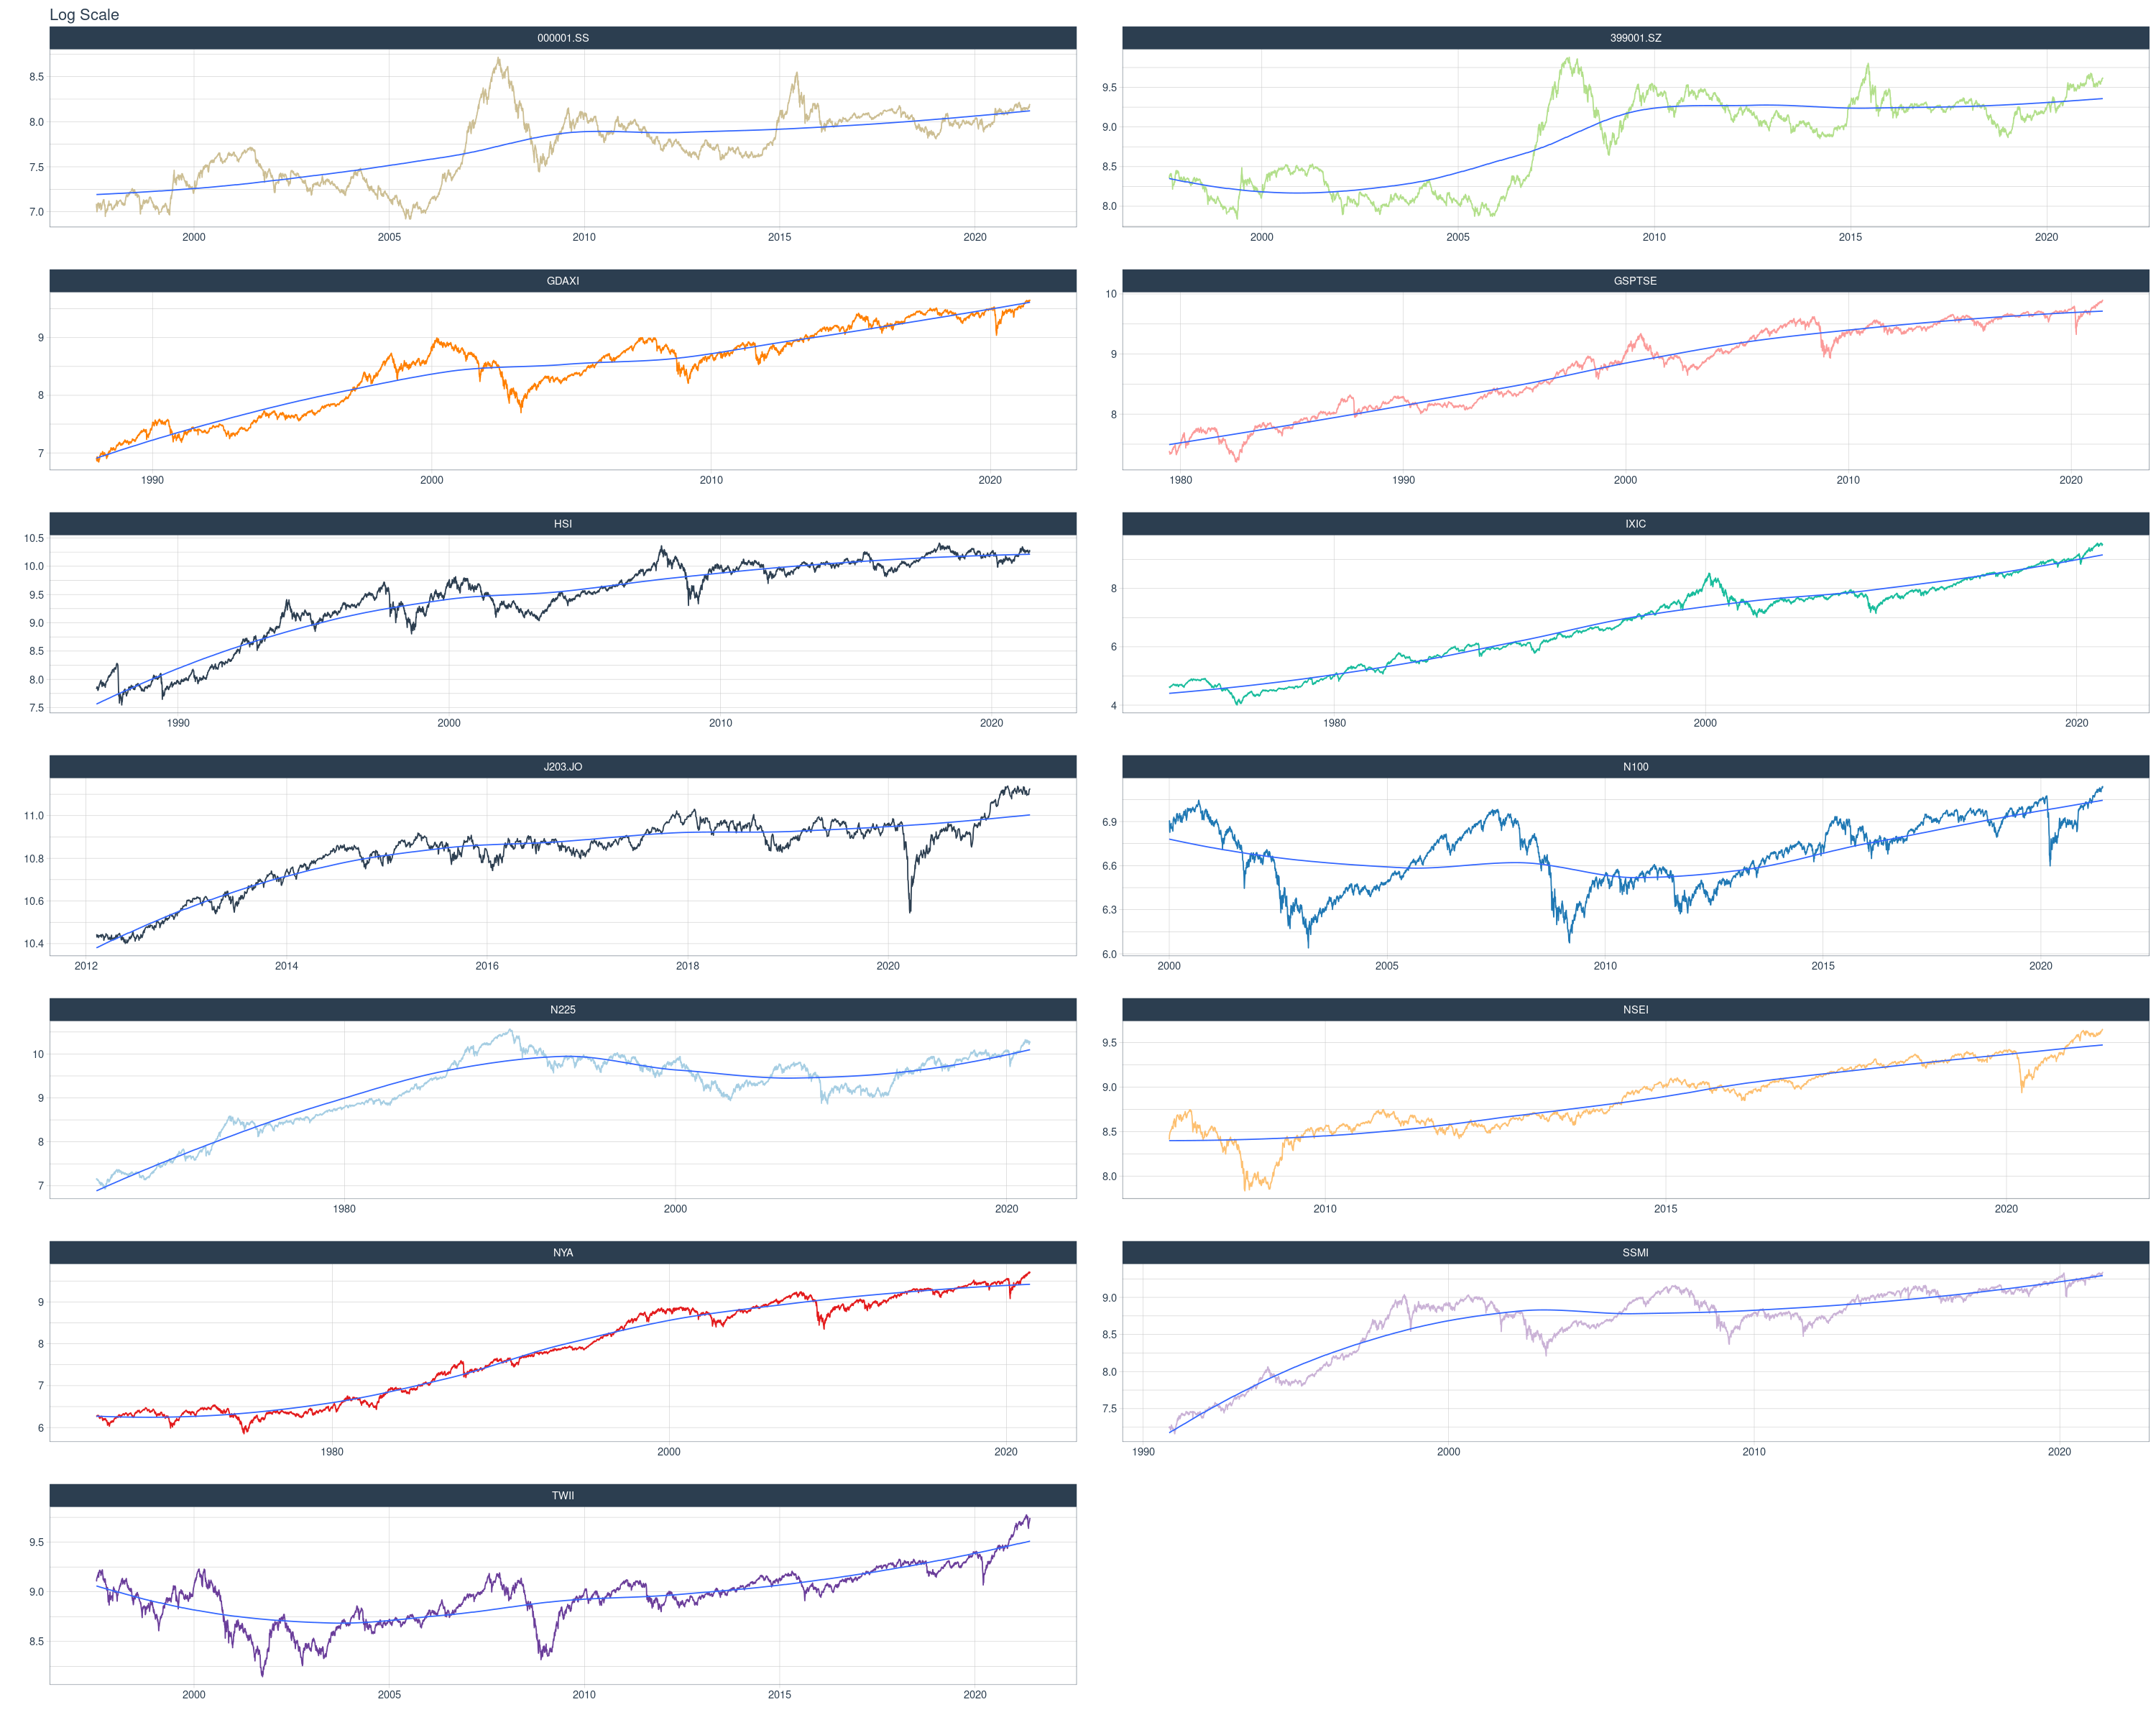

In [7]:
# plot all the series
options(repr.plot.width = 25, repr.plot.height = 20)
data %>% 
    mutate(Year = year(Date)) %>%
    plot_time_series(Date, AdjClose, 
                     .facet_vars = Index,
                     .color_var = Index,
                     .smooth_size = 0.5, 
                     .facet_ncol = 2,
                     .facet_scales = "free",
                     .interactive = FALSE,
                     .legend_show = FALSE,
                     .title = ""
                     )

data %>% 
    mutate(Year = year(Date)) %>%
    plot_time_series(Date, log(AdjClose), 
                     .facet_vars = Index,
                     .color_var = Index,
                     .smooth_size = 0.5, 
                     .facet_ncol = 2,
                     .facet_scales = "free",
                     .interactive = FALSE,
                     .legend_show = FALSE,
                     .title = "Log Scale"
                     )

In [8]:
# choose a series and split the data into a training and test set
data <- data %>% 
    filter(Index == "N100") %>% 
    select(-Index)

splits <- initial_time_split(data, prop = 0.8)

## Step 2: Create and fit models

In [9]:
# model 1: ARIMA
arima <- arima_reg() %>%
    set_engine(engine = "auto_arima") %>%
    fit(AdjClose ~ Date, data = training(splits))

frequency = 5 observations per 1 week



In [10]:
# model 2: boosted ARIMA
boosted_arima <- arima_boost(
        min_n = 2,
        learn_rate = 0.015
        ) %>%
    set_engine(engine = "auto_arima_xgboost") %>%
    fit(AdjClose ~ Date + as.numeric(Date) + factor(month(Date, label = TRUE), ordered = FALSE) + factor(wday(Date, label = TRUE, week_start = getOption("lubridate.week.start", 1)), ordered = FALSE),
        data = training(splits))

frequency = 5 observations per 1 week



In [11]:
# model 3: ETS / exponential smoothing
ets <- exp_smoothing() %>%
    set_engine(engine = "ets") %>%
    fit(AdjClose ~ Date, data = training(splits))

frequency = 5 observations per 1 week



In [12]:
# model 4: prophet
prophet <- prophet_reg() %>%
    set_engine(engine = "prophet") %>%
    fit(AdjClose ~ Date, data = training(splits))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [13]:
# model 5: linear regression
linear_reg <- linear_reg() %>%
    set_engine(engine = "lm") %>%
    fit(AdjClose ~ as.numeric(Date) + factor(month(Date, label = TRUE), ordered = FALSE) + factor(wday(Date, label = TRUE, week_start = getOption("lubridate.week.start", 1)), ordered = FALSE),
        data = training(splits))

In [14]:
# model 6: multivariate adaptie regression spline (MARS)
mars_model <- mars(mode = "regression") %>% set_engine("earth")

mars_recipe <- recipe(AdjClose ~ Date, data = training(splits)) %>%
    step_date(Date, features = c("dow", "month"), ordinal = FALSE) %>%
    step_mutate(DateNum = as.numeric(Date)) %>%
    step_normalize(DateNum) %>%
    step_rm(Date)

wflw_mars <- workflow() %>%
    add_recipe(mars_recipe) %>%
    add_model(mars_model) %>%
    fit(training(splits))

## Step 3: Add fitted models to a modeltime table

This step does some basic checking to ensure that each model has been fitted to the data before constructing a modeltime table that feeds into the forecasting workflow. The author of the package notes that it's expected that hyperparameter tuning and parameter selection is before prior to this step.

In [21]:
arima

parsnip model object

Series: outcome 
ARIMA(3,1,0)(2,0,0)[5] 

Coefficients:
          ar1      ar2      ar3     sar1     sar2
      -0.0150  -0.0265  -0.0427  -0.0494  -0.0271
s.e.   0.0151   0.0151   0.0151   0.0152   0.0152

sigma^2 = 93.81:  log likelihood = -16150.4
AIC=32312.79   AICc=32312.81   BIC=32351.1

In [ ]:
models_tbl <- modeltime_table(
    arima
    # boosted_arima,
    # ets,
    # prophet,
    # linear_reg,
    # wflw_mars
)

models_tbl

In [23]:
library(tidyverse)
library(lubridate)
library(timetk)
library(parsnip)
library(rsample)
library(modeltime)

# Data
m750 <- m4_monthly %>% filter(id == "M750")

# Split Data 80/20
splits <- initial_time_split(m750, prop = 0.9)

# --- MODELS ---

# Model 1: prophet ----
model_fit_prophet <- prophet_reg() %>%
    set_engine(engine = "prophet") %>%
    fit(value ~ date, data = training(splits))


# ---- MODELTIME TABLE ----

# Make a Modeltime Table
models_tbl <- modeltime_table(
    model_fit_prophet
)

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [24]:
models_tbl

ERROR: Error: No method asJSON S3 class: model_fit


## Step 4: Calibrate the model(s) to a test set

This step adds a new column containing test predictions and residuals calculated from out-of-sample data. Calibration is how confidence intervals and model performance/accuracy metrics are calculated.

- https://cran.r-project.org/web/packages/modeltime/vignettes/getting-started-with-modeltime.html
- https://www.youtube.com/watch?v=-bCelif-ENY
- https://www.youtube.com/watch?v=FlDCM1l6XEU
- https://business-science.github.io/modeltime/articles/modeltime-model-list.html
- https://www.r-bloggers.com/2020/06/introducing-modeltime-tidy-time-series-forecasting-using-tidymodels/